<a href="https://colab.research.google.com/github/drpeppurr/yamcha/blob/main/tutorial/YAMCHA_tutorial_ch9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Load packages etc

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from scipy.integrate import solve_ivp,cumulative_trapezoid
from matplotlib.colors import LogNorm

# Note: might need to set this high if running very big mechanisms, like the full MCM..
#       3000 seems to be sufficient for full MCM.
# import sys
# sys.setrecursionlimit(3000)

2. These are some functionalities to load/process the KPP files generated from the MCM website: <br>https://mcm.york.ac.uk/MCM <br>
Make sure to check "inorganic chemistry" and the "generic rate coefficients".
<br>

In [95]:
# ======================================
# photolysis frequency (j-value) mapping
# ======================================
kpp_jval_mapping = pd.DataFrame({' J_O3_O1D ': ['J1'],       ' J_O3_O3P ': ['J2'],
                                 ' J_H2O2 ': ['J3'],         ' J_NO2 ': ['J4'],
                                 ' J_NO3_NO ': ['J5'],       ' J_NO3_NO2 ': ['J6'],
                                 ' J_HONO ': ['J7'],         ' J_HNO3 ': ['J8'],
                                 ' J_HCHO_H ': ['J11'],      ' J_HCHO_H2 ': ['J12'],
                                 ' J_CH3CHO ': ['J13'],      ' J_C2H5CHO ': ['J14'],
                                 ' J_C3H7CHO_HCO ': ['J15'], ' J_C3H7CHO_C2H4 ': ['J16'],
                                 ' J_IPRCHO ': ['J17'],      ' J_MACR_HCO ': ['J18'],
                                 ' J_MACR_H ': ['J19'],      ' J_C5HPALD1 ': ['J20'],
                                 ' J_CH3COCH3 ': ['J21'],    ' J_MEK ': ['J22'],
                                 ' J_MVK_CO ': ['J23'],      ' J_MVK_C2H3 ': ['J24'],
                                 ' J_GLYOX_H2 ': ['J31'],    ' J_GLYOX_HCHO ': ['J32'],
                                 ' J_GLYOX_HCO ': ['J33'],   ' J_MGLYOX ': ['J34'],
                                 ' J_BIACET ': ['J35'],      ' J_CH3OOH ': ['J41'],
                                 ' J_CH3NO3 ': ['J51'],      ' J_C2H5NO3 ': ['J52'],
                                 ' J_NC3H7NO3 ': ['J53'],    ' J_IC3H7NO3 ': ['J54'],
                                 ' J_TC4H9NO3 ': ['J55'],    ' J_NOA ': ['J56'],
                                })
kpp_jval_mapping.index = ['J_label']
kpp_jval_mapping.T


# ================================
# this is the main KPP file loader
# ================================
def load_mcm_kpp(in_mcm_kpp):
    f = open(in_mcm_kpp, "r")
    f_contents = f.readlines()
    f.close()
    # --- find the start of mechanism
    for i,l in enumerate(f_contents):
        if ((' RO2 = ' in l) & ('&' in l)) | ((' RO2 = ' in l) & ('C(ind_' in l)):
            ro2_linenum_start = i
            for n,l2 in enumerate(f_contents[ro2_linenum_start+1:]):
                if 'C(ind_' not in l2:
                    ro2_linenum_end = n + ro2_linenum_start
                    break
        if '#EQUATIONS' in l:
            header_linenum = i
            break
    # --- process RO2 list
    try:
        RO2_list = ' '.join(f_contents[ro2_linenum_start:ro2_linenum_end+1])
        RO2_list = RO2_list.replace('\n','').replace('&','').replace(' ','').replace('RO2=','').replace('C(ind_','').replace(')','')
        RO2_list = RO2_list.split('+')
    except: RO2_list = ''
    # --- get id, reactions, and rate coeff
    reaction_ind,reaction,ratecoeff = [],[],[]
    for l in f_contents[header_linenum+1:]:
        if (':' in l) & ((';' in l)):
            reaction_ind.append(l.replace('\t','').split(':')[0].split('>')[0].replace('<',''))  # 20250402: they changed kpp format.. this works for new kpp but not old ones.. perhaps replace {} with <> so it'll retro compatible?
            reaction.append(l.replace('\t','').split(':')[0].split('>')[1])
            ratecoeff.append(l.replace('\t','').split(':')[1].replace(';','').replace('\n',''))
    # --- housekeeping
    reaction_ind = ['R'+str(int(ind)-1) for ind in reaction_ind]
    ratecoeff = [r.replace(' ','') for r in ratecoeff]
    ratecoeff = [r.replace('EXP','np.exp') for r in ratecoeff]
    ratecoeff = [r.replace('TEMP','temp') for r in ratecoeff]
    ratecoeff = [r.replace('D+','e+') for r in ratecoeff]
    ratecoeff = [r.replace('D-','e-') for r in ratecoeff]
    ratecoeff = [r.replace('J(','jval[ ').replace(')',' ]') if 'J(' in r else r for r in ratecoeff]
    ratecoeff2 = []
    for r in ratecoeff: # this is sloppy...
        if 'D' in r:
            loc_of_fucking_D = r.find('D')
            if (r[loc_of_fucking_D-1].isnumeric()) & (r[loc_of_fucking_D+1].isnumeric()):
                ratecoeff2.append(r.replace('D','e'))
            else: ratecoeff2.append(r)
        else: ratecoeff2.append(r)
    ratecoeff = ratecoeff2
    # --- remove hv: 20250402: they changed kpp format..
    reaction2 = []
    for i,r in enumerate(reaction):
        if '+hv' in r.replace(' ',''):
            reaction2.append(' '+r.replace(' ','').replace('+hv','').replace('+',' + ').replace('=',' = ')+' ')
        else: reaction2.append(r)
    reaction = reaction2
    # --- update j-label: this works for new kpp and may also work for old ones..
    for i,r in enumerate(ratecoeff):
        if 'jval[' in r:
            jr_update = r
            for jlabel in kpp_jval_mapping.T['J_label'].index:
                if jlabel in jr_update:
                    jr_update = jr_update.replace(jlabel, kpp_jval_mapping.T['J_label'][ jlabel ].replace('J',''))
            ratecoeff[i] = jr_update
    # --- pack
    mcm_kpp = pd.DataFrame([reaction,ratecoeff,RO2_list]).transpose()
    mcm_kpp.columns = ['reaction', 'rate_coefficient','RO2']
    ChemMech = mcm_kpp.T.copy()
    ChemMech.columns = reaction_ind
    return ChemMech#,RO2_list


3. These are the chemical mechanism parser and related utilities:<br>
- pre_process(...): this processes the mechanism, then generate the derivatives (dC/dt)
- get_jac(...): this calculates the Jacobian matrix. makes the solver faster!
- mcm_jval(...): photolysis frequencies, which are based on MCM (parameterized as a function of solar zenith angle)
- pd_mcm_kinetics(...): generic rate coefficients, also from MCM.

In [96]:
# ================
# Jacobian matrix!
# ================
def get_jac(full_dcodt,rates):
    jac = []
    for i,dcodt in enumerate(full_dcodt):
        rhs_dcodt = dcodt.replace('\n','').replace('\\','').replace(' ','').split('=')[1]
        rhs_dcodt = rhs_dcodt.replace('+',',+').replace('-',',-').split(',')[1:]
        rhs_dcodt2 = [] # convert rates to expressions
        for dcodt in rhs_dcodt:
            # rate_ind = int(dcodt.replace('+rate[','').replace('-rate[','').replace('rate[','').replace(']',''))
            rate_ind = int(dcodt.split('rate[')[1].split(']')[0])
            rhs_dcodt2.append(dcodt.replace('rate['+str(rate_ind)+']', rates[rate_ind]))
        rhs_dcodt = rhs_dcodt2.copy()
        del rhs_dcodt2
        jac_row = []
        for n in range(len(full_dcodt)):
            dfodc = '0.'
            c_n = 'conc['+str(n)+']'
            for dcodt in rhs_dcodt:
                order_c_n = dcodt.split('*').count(c_n)
                if order_c_n==2: dfodc = dfodc + dcodt.split('*')[0]+'*2.*'+c_n
                if order_c_n==1: dfodc = dfodc + dcodt.replace('*'+c_n,'')
            if (dfodc!='0.'): jac_row.append('jac_out[%d,%d] = %s' % (i,n,dfodc))
        jac.append('\n'.join(jac_row))
    return '\n'.join(jac)

# =================================
# this procedure does two things:
#  - process the chemical mechanism
#  - generate the "derivatives"
# =================================
def pre_process(in_ChemMech, diagnostic=False):
    line_limit_rate_expres = 60  #...so we don't end up with ridiculously long lines...
    # --- clean up reactions
    reactions = [in_ChemMech[rnd]['reaction'] for rnd in in_ChemMech.columns]
    reactions = [' '+rnd.replace(' ','')+' ' for rnd in reactions]
    reactions = [rnd.replace('+',' + ') for rnd in reactions]
    reactions = [rnd.replace('=',' = ') for rnd in reactions]
    # --- rate coefficient expressions
    rate_coeff_express_2eval = [str(in_ChemMech[rnd]['rate_coefficient']) for rnd in in_ChemMech.columns]
    rate_coeff_express_2eval = [r.replace('EXP','np.exp') for r in rate_coeff_express_2eval]
    rate_coeff_express_2eval = [r.replace('TEMP','temp') for r in rate_coeff_express_2eval]
    rate_coeff_express_2eval = [r.replace('^','**') for r in rate_coeff_express_2eval]
    # --- generate species list based on that
    species_temp = ','.join(reactions)                                 # concatenate
    species_temp = species_temp.replace(' ','')                        # remove all spaces
    for s in ['+','=','*']: species_temp = species_temp.replace(s,',') # chop chop
    species_temp = list(np.unique(species_temp.split(',')))            # keep only unique stuff
    species_list = []
    for spc in species_temp:
        if (spc.replace('.','').isnumeric()==False) & (len(spc)>0): species_list.append(spc) # delete numerical (stoichiometric coefficients)
    # --- now process RO2 list
    RO2_sum = 'RO2=0.0'
    if 'RO2' in in_ChemMech.T.columns:
        RO2_list = [r for r in list(in_ChemMech.T['RO2']) if r]
        linelength_current_RO2 = 0
        if (len(RO2_list)>0):
            for RO2 in RO2_list:
                if (linelength_current_RO2<=line_limit_rate_expres):
                    linelength_current_RO2 = linelength_current_RO2 + len('+conc[' + str(species_list.index(RO2)) + ']')
                    RO2_sum = RO2_sum + '+conc[' + str(species_list.index(RO2)) + ']'
                else:
                    linelength_current_RO2 = 0
                    RO2_sum = RO2_sum + '\ \n' + '+conc[' + str(species_list.index(RO2)) + ']'
        RO2_sum = RO2_sum.replace('\ ','\\')
    if (diagnostic): print(RO2_sum)
    # ===============================================================
    # Okay this generates the derivatives, and save as a list strings
    # then these are "evaluated" and recognized as math expressions
    # ===============================================================
    # --- generate the rates for each reaction
    rates_2eval = []
    for ind_reac,reaction in enumerate(reactions):
        all_reactants = [r.replace(' ','') for r in reaction.split(' = ')[0].split(' + ')]
        # --- 20250407: add support for zero-order reactions
        if len(''.join(all_reactants).replace(' ',''))!=0:    # non-zero order reactions
            all_reactants_conc = ['conc['+str(species_list.index(r))+']' for r in all_reactants]
            rates_2eval.append('rate_coeff[' +str(ind_reac) + ']*' + '*'.join(all_reactants_conc))
        else:                                                 # zero order reactions
            all_reactants_conc = ''
            rates_2eval.append('rate_coeff[' +str(ind_reac) + ']')
    # --- generate the derivative for each compound
    derivatives_expres_2eval = []
    full_dcodt_out = []
    for ind_spc,spc in enumerate(species_list):
        dcodt_spc = '0.'
        lengh_rate_expres_currentline = 0
        if (diagnostic): print('# ---')
        if (diagnostic): print('# ', spc)
        for ind_reac,reaction in enumerate(reactions):
            loc_spc = reaction.replace('*',' ').find(' '+spc+' ')
            # --- only do these if found this compound in this reaction
            if loc_spc>=0:
                all_reactants = [r.replace(' ','') for r in reaction.split(' = ')[0].split(' + ')]
                all_products = [r.replace(' ','') for r in reaction.split(' = ')[1].split(' + ')]
                # --- get rid of stoichiometric coefficients
                all_reactants_nostoic, all_products_nostoic = [],[]
                for s in all_reactants:
                    if s.find('*')>=0: all_reactants_nostoic.append(s.split('*')[1])
                    else: all_reactants_nostoic.append(s)
                for s in all_products:
                    if s.find('*')>=0: all_products_nostoic.append(s.split('*')[1])
                    else: all_products_nostoic.append(s)
                # print(all_reactants, all_products, all_products_nostoic)
                # --- get stoiciometric coefficients
                reaction_temp = reaction.replace(' ','')
                for s in ['+','=']: reaction_temp = reaction_temp.replace(s,',') # chop chop
                reaction_temp = reaction_temp.split(',')
                reaction_stoic = []
                for s in reaction_temp:
                    if s.find('*')>=0: reaction_stoic.append(float(s.split('*')[0]))
                    else: reaction_stoic.append(1)
                # --- overall loc for the species in this reaction
                reaction_temp2 = [] # without stoichiometric coefficient
                for s in reaction_temp:
                    if s.find('*')>=0: reaction_temp2.append(s.split('*')[1])
                    else: reaction_temp2.append(s)
                # --- get rate expression for each reaction
                rate_expres = ''
                # for n_reactant,reactant in enumerate(reaction.split(' = ')[0].split(' + ')):
                #     ind_reactant = species_list.index(reactant.replace(' ',''))
                #     rate_expres = rate_expres + '*conc[%d]' % (ind_reactant)
                # rate_expres = 'rate_coeff[' +str(ind_reac) + ']' + rate_expres
                rate_expres = 'rate[' +str(ind_reac) + ']' # + rate_expres
                # --- check if spc is a reactant or a product, then put everything together
                stoic = reaction_stoic[reaction_temp2.index(spc)]
                for (reactants_or_products,sign) in zip([all_reactants_nostoic,all_products_nostoic],['-','+']):
                    for s in reactants_or_products:
                        if (s==spc): # need to search for all entrys!!!
                            # --- line length constrain
                            if (lengh_rate_expres_currentline>=line_limit_rate_expres):
                                dcodt_spc = dcodt_spc + '   \ \n'
                                lengh_rate_expres_currentline = 0
                            # --- now make the rate extression
                            if (stoic==1.):
                                dcodt_spc = dcodt_spc + sign + rate_expres
                                lengh_rate_expres_currentline = lengh_rate_expres_currentline + len(rate_expres)
                            else:
                                dcodt_spc = dcodt_spc + sign + str(stoic) + '*' + rate_expres
                                lengh_rate_expres_currentline = lengh_rate_expres_currentline + len(rate_expres)
        # --- output
        full_dcodt = 'dcodt_out[%d] = %s' % (ind_spc,dcodt_spc)
        full_dcodt = full_dcodt.replace('\ ','\\')
        # full_dcodt_out = full_dcodt_out + full_dcodt +'\n'
        full_dcodt_out.append(full_dcodt)
        if (diagnostic): print(full_dcodt)
        derivatives_expres_2eval.append(dcodt_spc.replace('\ ','\\'))
    # --- now get the jacobian metrix
    jac_2eval = get_jac(full_dcodt_out,rates_2eval)
    return species_list, reactions, rates_2eval, derivatives_expres_2eval, rate_coeff_express_2eval, jac_2eval, RO2_sum


def mcm_jval(SZA):
    jval = np.zeros(100)
    jval[1] = 6.073E-05*np.cos(SZA)**1.743*np.exp(-1*0.474*np.cos(SZA)**-1)
    jval[2] = 4.775E-04*np.cos(SZA)**0.298*np.exp(-1*0.08*np.cos(SZA)**-1)
    jval[3] = 1.041E-05*np.cos(SZA)**0.723*np.exp(-1*0.279*np.cos(SZA)**-1)
    jval[4] = 1.165E-02*np.cos(SZA)**0.244*np.exp(-1*0.267*np.cos(SZA)**-1)
    jval[5] = 2.485E-02*np.cos(SZA)**0.168*np.exp(-1*0.108*np.cos(SZA)**-1)
    jval[6] = 1.747E-01*np.cos(SZA)**0.155*np.exp(-1*0.125*np.cos(SZA)**-1)
    jval[7] = 2.644E-03*np.cos(SZA)**0.261*np.exp(-1*0.288*np.cos(SZA)**-1)
    jval[8] = 9.312E-07*np.cos(SZA)**1.23*np.exp(-1*0.307*np.cos(SZA)**-1) # HNO3
    jval[11] = 4.642E-05*np.cos(SZA)**0.762*np.exp(-1*0.353*np.cos(SZA)**-1)
    jval[12] = 6.853E-05*np.cos(SZA)**0.477*np.exp(-1*0.323*np.cos(SZA)**-1)
    jval[13] = 7.344E-06*np.cos(SZA)**1.202*np.exp(-1*0.417*np.cos(SZA)**-1)
    jval[14] = 2.879E-05*np.cos(SZA)**1.067*np.exp(-1*0.358*np.cos(SZA)**-1)
    jval[15] = 2.792E-05*np.cos(SZA)**0.805*np.exp(-1*0.338*np.cos(SZA)**-1)
    jval[16] = 1.675E-05*np.cos(SZA)**0.805*np.exp(-1*0.338*np.cos(SZA)**-1)
    jval[17] = 7.914E-05*np.cos(SZA)**0.764*np.exp(-1*0.364*np.cos(SZA)**-1)
    jval[18] = 1.482E-06*np.cos(SZA)**0.396*np.exp(-1*0.298*np.cos(SZA)**-1)
    jval[19] = 1.482E-06*np.cos(SZA)**0.396*np.exp(-1*0.298*np.cos(SZA)**-1)
    jval[20] = 7.600E-04*np.cos(SZA)**0.396*np.exp(-1*0.298*np.cos(SZA)**-1)
    jval[21] = 7.992E-07*np.cos(SZA)**1.578*np.exp(-1*0.271*np.cos(SZA)**-1)
    jval[22] = 5.804E-06*np.cos(SZA)**1.092*np.exp(-1*0.377*np.cos(SZA)**-1)
    jval[23] = 2.4246E-06*np.cos(SZA)**0.395*np.exp(-1*0.296*np.cos(SZA)**-1)
    jval[24] = 2.424E-06*np.cos(SZA)**0.395*np.exp(-1*0.296*np.cos(SZA)**-1)
    jval[31] = 6.845E-05*np.cos(SZA)**0.13*np.exp(-1*0.201*np.cos(SZA)**-1)
    jval[32] = 1.032E-05*np.cos(SZA)**0.13*np.exp(-1*0.201*np.cos(SZA)**-1)
    jval[33] = 3.802E-05*np.cos(SZA)**0.644*np.exp(-1*0.312*np.cos(SZA)**-1)
    jval[34] = 1.537E-04*np.cos(SZA)**0.17*np.exp(-1*0.208*np.cos(SZA)**-1)
    jval[35] = 3.326E-04*np.cos(SZA)**0.148*np.exp(-1*0.215*np.cos(SZA)**-1)
    jval[41] = 7.649E-06*np.cos(SZA)**0.682*np.exp(-1*0.279*np.cos(SZA)**-1)
    jval[51] = 1.588E-06*np.cos(SZA)**1.154*np.exp(-1*0.318*np.cos(SZA)**-1) # CH3NO3
    jval[52] = 1.907E-06*np.cos(SZA)**1.244*np.exp(-1*0.335*np.cos(SZA)**-1)
    jval[53] = 2.485E-06*np.cos(SZA)**1.196*np.exp(-1*0.328*np.cos(SZA)**-1)
    jval[54] = 4.095E-06*np.cos(SZA)**1.111*np.exp(-1*0.316*np.cos(SZA)**-1)
    jval[55] = 1.135E-05*np.cos(SZA)**0.974*np.exp(-1*0.309*np.cos(SZA)**-1)
    jval[56] = 4.365E-05*np.cos(SZA)**1.089*np.exp(-1*0.323*np.cos(SZA)**-1)
    jval[61] = 7.537E-04*np.cos(SZA)**0.499*np.exp(-1*0.266*np.cos(SZA)**-1)
    return jval

# --- pulled from MCM website...
def pd_mcm_kinetics(temp,M,N2,O2,H2O,NO=0.,HO2=0.,RO2=0.,NO3=0.):
    KRO2NO = 2.7e-12*np.exp(360/temp)
    KRO2HO2 = 2.91e-13*np.exp(1300/temp)
    KAPHO2 = 5.2e-13*np.exp(980/temp)
    KAPNO = 7.5e-12*np.exp(290/temp)
    KRO2NO3 = 2.3e-12
    KNO3AL = 1.44e-12*np.exp(-1862/temp)
    KDEC = 1.00e+06
    KROPRIM = 2.50e-14*np.exp(-300/temp)
    KROSEC = 2.50e-14*np.exp(-300/temp)
    KCH3O2 = 1.03e-13*np.exp(365/temp)
    K298CH3O2 = 3.5e-13
    K14ISOM1 = 3.00e+7*np.exp(-5300/temp)
    KD0 = 1.10e-05*M*np.exp(-10100/temp)
    KDI = 1.90e+17*np.exp(-14100/temp)
    KRD = KD0/KDI
    FCD = 0.30
    NCD = 0.75-1.27*(np.log10(FCD))
    FD = 10**(np.log10(FCD)/(1+(np.log10(KRD)/NCD)**2))
    KBPAN = (KD0*KDI)*FD/(KD0+KDI)
    KC0 = 3.28e-28*M*(temp/300)**-6.87
    KCI = 1.125e-11*(temp/300)**-1.105
    KRC = KC0/KCI
    FCC = 0.30
    NC = 0.75-1.27*(np.log10(FCC))
    FC = 10**(np.log10(FCC)/(1+(np.log10(KRC)/NC)**2))
    KFPAN = (KC0*KCI)*FC/(KC0+KCI)
    K10 = 1.0e-31*M*(temp/300)**-1.6
    K1I = 5.0e-11*(temp/300)**-0.3
    KR1 = K10/K1I
    FC1 = 0.85
    NC1 = 0.75-1.27*(np.log10(FC1))
    F1 = 10**(np.log10(FC1)/(1+(np.log10(KR1)/NC1)**2))
    KMT01 = (K10*K1I)*F1/(K10+K1I)
    K20 = 1.3e-31*M*(temp/300)**-1.5
    K2I = 2.3e-11*(temp/300)**0.24
    KR2 = K20/K2I
    FC2 = 0.6
    NC2 = 0.75-1.27*(np.log10(FC2))
    F2 = 10**(np.log10(FC2)/(1+(np.log10(KR2)/NC2)**2))
    KMT02 = (K20*K2I)*F2/(K20+K2I)
    K30 = 3.6e-30*M*(temp/300)**-4.1
    K3I = 1.9e-12*(temp/300)**0.2
    KR3 = K30/K3I
    FC3 = 0.35
    NC3 = 0.75-1.27*(np.log10(FC3))
    F3 = 10**(np.log10(FC3)/(1+(np.log10(KR3)/NC3)**2))
    KMT03 = (K30*K3I)*F3/(K30+K3I)
    K40 = 1.3e-3*M*(temp/300)**-3.5*np.exp(-11000/temp)
    K4I = 9.7e+14*(temp/300)**0.1*np.exp(-11080/temp)
    KR4 = K40/K4I
    FC4 = 0.35
    NC4 = 0.75-1.27*(np.log10(FC4))
    F4 = 10**(np.log10(FC4)/(1+(np.log10(KR4)/NC4)**2))
    KMT04 = (K40*K4I)*F4/(K40+K4I)
    KMT05 = 1.44e-13*(1+(M/4.2e+19))
    KMT06 = 1 + (1.40e-21*np.exp(2200/temp)*H2O)
    K70 = 7.4e-31*M*(temp/300)**-2.4
    K7I = 3.3e-11*(temp/300)**-0.3
    KR7 = K70/K7I
    FC7 = 0.81
    NC7 = 0.75-1.27*(np.log10(FC7))
    F7 = 10**(np.log10(FC7)/(1+(np.log10(KR7)/NC7)**2))
    KMT07 = (K70*K7I)*F7/(K70+K7I)
    K80 = 3.2e-30*M*(temp/300)**-4.5
    K8I = 3.0e-11
    KR8 = K80/K8I
    FC8 = 0.41
    NC8 = 0.75-1.27*(np.log10(FC8))
    F8 = 10**(np.log10(FC8)/(1+(np.log10(KR8)/NC8)**2))
    KMT08 = (K80*K8I)*F8/(K80+K8I)
    K90 = 1.4e-31*M*(temp/300)**-3.1
    K9I = 4.0e-12
    KR9 = K90/K9I
    FC9 = 0.4
    NC9 = 0.75-1.27*(np.log10(FC9))
    F9 = 10**(np.log10(FC9)/(1+(np.log10(KR9)/NC9)**2))
    KMT09 = (K90*K9I)*F9/(K90+K9I)
    K100 = 4.10e-05*M*np.exp(-10650/temp)
    K10I = 6.0e+15*np.exp(-11170/temp)
    KR10 = K100/K10I
    FC10 = 0.4
    NC10 = 0.75-1.27*(np.log10(FC10))
    F10 = 10**(np.log10(FC10)/(1+(np.log10(KR10)/NC10)**2))
    KMT10 = (K100*K10I)*F10/(K100+K10I)
    K1 = 2.40e-14*np.exp(460/temp)
    K3 = 6.50e-34*np.exp(1335/temp)
    K4 = 2.70e-17*np.exp(2199/temp)
    K2 = (K3*M)/(1+(K3*M/K4))
    KMT11 = K1 + K2
    K120 = 2.5e-31*M*(temp/300)**-2.6
    K12I = 2.0e-12
    KR12 = K120/K12I
    FC12 = 0.53
    NC12 = 0.75-1.27*(np.log10(FC12))
    F12 = 10**(np.log10(FC12)/(1.0+(np.log10(KR12)/NC12)**2))
    KMT12 = (K120*K12I*F12)/(K120+K12I)
    K130 = 2.5e-30*M*(temp/300)**-5.5
    K13I = 1.8e-11
    KR13 = K130/K13I
    FC13 = 0.36
    NC13 = 0.75-1.27*(np.log10(FC13))
    F13 = 10**(np.log10(FC13)/(1+(np.log10(KR13)/NC13)**2))
    KMT13 = (K130*K13I)*F13/(K130+K13I)
    K140 = 9.0e-5*np.exp(-9690/temp)*M
    K14I = 1.1e+16*np.exp(-10560/temp)
    KR14 = K140/K14I
    FC14 = 0.36
    NC14 = 0.75-1.27*(np.log10(FC14))
    F14 = 10**(np.log10(FC14)/(1+(np.log10(KR14)/NC14)**2))
    KMT14 = (K140*K14I)*F14/(K140+K14I)
    K150 = 8.6e-29*M*(temp/300)**-3.1
    K15I = 9.0e-12*(temp/300)**-0.85
    KR15 = K150/K15I
    FC15 = 0.48
    NC15 = 0.75-1.27*(np.log10(FC15))
    F15 = 10**(np.log10(FC15)/(1+(np.log10(KR15)/NC15)**2))
    KMT15 = (K150*K15I)*F15/(K150+K15I)
    K160 = 8e-27*M*(temp/300)**-3.5
    K16I = 3.0e-11*(temp/300)**-1
    KR16 = K160/K16I
    FC16 = 0.5
    NC16 = 0.75-1.27*(np.log10(FC16))
    F16 = 10**(np.log10(FC16)/(1+(np.log10(KR16)/NC16)**2))
    KMT16 = (K160*K16I)*F16/(K160+K16I)
    K170 = 5.0e-30*M*(temp/300)**-1.5
    K17I = 1.0e-12
    KR17 = K170/K17I
    FC17 = 0.17*np.exp(-51/temp)+np.exp(-temp/204)
    NC17 = 0.75-1.27*(np.log10(FC17))
    F17 = 10**(np.log10(FC17)/(1.0+(np.log10(KR17)/NC17)**2))
    KMT17 = (K170*K17I*F17)/(K170+K17I)
    KMT18 = 9.5e-39*O2*np.exp(5270/temp)/(1+7.5e-29*O2*np.exp(5610/temp))
    KPPN0 = 1.7e-03*np.exp(-11280/temp)*M
    KPPNI = 8.3e+16*np.exp(-13940/temp)
    KRPPN = KPPN0/KPPNI
    FCPPN = 0.36
    NCPPN = 0.75-1.27*(np.log10(FCPPN))
    FPPN = 10**(np.log10(FCPPN)/(1+(np.log10(KRPPN)/NCPPN)**2))
    KBPPN = (KPPN0*KPPNI)*FCPPN/(KPPN0+KPPNI)
    KNO = KRO2NO*NO
    KHO2 = KRO2HO2*HO2*0.706
    KRO2 = 1.26e-12*RO2
    KNO3 = KRO2NO3*NO3
    KTR = KNO + KHO2 + KRO2 + KNO3
    K16ISOM = (KTR*5.18e-04*np.exp(1308/temp)) +(2.76e+07*np.exp(-6759/temp))
    # --- pack... this is a bit sloppy
    k_val = [KRO2NO,KRO2HO2,KAPHO2,KAPNO,KRO2NO3,KNO3AL,KDEC,KROPRIM,KROSEC,KCH3O2,K298CH3O2,K14ISOM1,KBPAN,KFPAN,
             KMT01,KMT02,KMT03,KMT04,KMT05,KMT06,KMT07,KMT08,
             KMT09,KMT10,KMT11,KMT12,KMT13,KMT14,KMT15,KMT16,KMT17,KMT18,KPPN0,KPPNI,KRPPN,FCPPN,NCPPN,FPPN,KBPPN,
             KNO,KHO2,KRO2,KNO3,KTR,K16ISOM]
    k_label = ['KRO2NO','KRO2HO2','KAPHO2','KAPNO','KRO2NO3','KNO3AL','KDEC','KROPRIM','KROSEC','KCH3O2','K298CH3O2','K14ISOM1',
               'KBPAN','KFPAN','KMT01','KMT02','KMT03','KMT04',
               'KMT05','KMT06','KMT07','KMT08','KMT09','KMT10','KMT11','KMT12','KMT13','KMT14','KMT15','KMT16','KMT17',
               'KMT18','KPPN0','KPPNI','KRPPN','FCPPN','NCPPN','FPPN','KBPPN','KNO','KHO2','KRO2','KNO3','KTR','K16ISOM']
    mcm_kin = pd.DataFrame(k_val,index=None).transpose()
    mcm_kin.columns = k_label
    return mcm_kin

# start_time = time.time()
# in_ChemMech = ChemMech
# # in_ChemMech = ChemMech_MCM_inorg
# species_list, reactions, rate_expres_2eval, rate_coeff_express_2eval, jac, RO2_sum = pre_process(in_ChemMech, True)
# species_list, reactions, rates_2eval, derivatives_expres_2eval, rate_coeff_express_2eval, jac_2eval, RO2_sum = pre_process(in_ChemMech)
# print(len(species_list))
# print('Done processing the mechanism in: %.6f seconds' % (time.time() - start_time))

<>:65: SyntaxWarning: invalid escape sequence '\ '
<>:66: SyntaxWarning: invalid escape sequence '\ '
<>:133: SyntaxWarning: invalid escape sequence '\ '
<>:144: SyntaxWarning: invalid escape sequence '\ '
<>:148: SyntaxWarning: invalid escape sequence '\ '
<>:65: SyntaxWarning: invalid escape sequence '\ '
<>:66: SyntaxWarning: invalid escape sequence '\ '
<>:133: SyntaxWarning: invalid escape sequence '\ '
<>:144: SyntaxWarning: invalid escape sequence '\ '
<>:148: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-1659816944.py:65: SyntaxWarning: invalid escape sequence '\ '
  RO2_sum = RO2_sum + '\ \n' + '+conc[' + str(species_list.index(RO2)) + ']'
/tmp/ipython-input-1659816944.py:66: SyntaxWarning: invalid escape sequence '\ '
  RO2_sum = RO2_sum.replace('\ ','\\')
/tmp/ipython-input-1659816944.py:133: SyntaxWarning: invalid escape sequence '\ '
  dcodt_spc = dcodt_spc + '   \ \n'
/tmp/ipython-input-1659816944.py:144: SyntaxWarning: invalid escape sequence '\ '
  full

4. Now need to load the chemical mechanism.<br>
You can load the KPP file generated from the MCM website (https://mcm.york.ac.uk/MCM) using the utility provided above.<br>
Note that KPP has multiple different "flavors", e.g. KPP files used in WRF-Chem and GEOS-Chem may look slightly different.<br>
Currently only KPP files from MCM will be supported, but adding support for other KPP files shouldn't be that different. Will follow up later.

In [97]:
# ==========================================================
# Use this to load the chemical mechanism file in KPP format
# ==========================================================
# ChemMech = load_mcm_kpp('/content/mcm_export_isoprene.eqn')
# ChemMech = load_mcm_kpp('/content/mcm_export_C1_C4.eqn')
# ChemMech = load_mcm_kpp('/content/mcm_export_toluene.eqn')
ChemMech = load_mcm_kpp('/content/cri_export_toluene.eqn')
ChemMech.T

,reaction,rate_coefficient,RO2
R0,OH + TOLUENE = RA16O2,1.8E-12*np.exp(340./temp)*0.82,RA16O2
R1,OH + TOLUENE = AROH17 + HO2,1.8E-12*np.exp(340./temp)*0.18,CH3O2
R2,HCHO = CO + HO2 + HO2,jval[11],C2H5O2
R3,HCHO = CO + H2,jval[12],CH3CO3
R4,CH3CHO = CH3O2 + CO + HO2,jval[13],C2H5CO3
...,...,...,...
R254,NO3 = NO2 + O,jval[6],None
R255,HONO = NO + OH,jval[7],None
R256,HNO3 = NO2 + OH,jval[8],None
R257,N2O5 = NO2 + NO3,KMT04,None


<br>
<br>
<br>

---


5. Setup the initial size distribution of the see aerosols

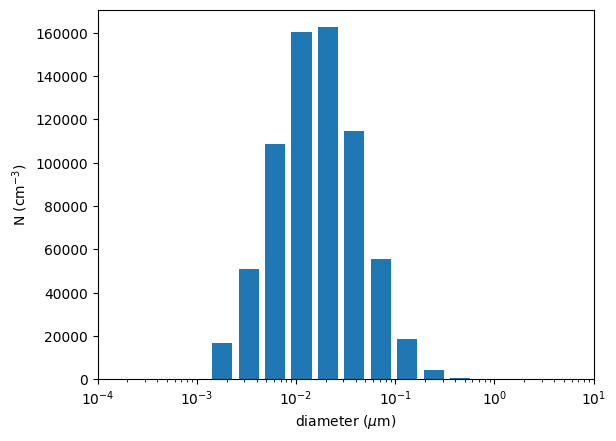

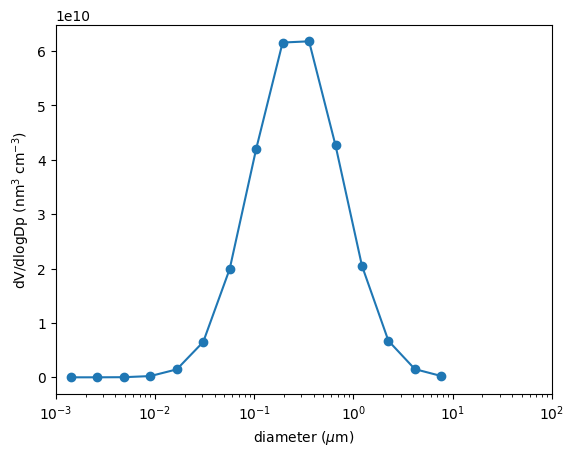

In [98]:
# =========================
# Model setup: aerosol bins
# =========================
N0 = 7e+5              # total aerosol number concentration (across all bins), cm^-3
Dp_mean_um = 0.012      # initial median diameter
sigma = 2.7           # aerosol size dist sigma

Dp_um = 10**np.arange(-4,1.501,0.001)

N_bins = 15
# init_Dp_bounds_um = 10**np.linspace(-3.5, 1.5, N_bins+1)
init_Dp_bounds_um = 10**np.linspace(-3, 1, N_bins+1)

# --- this is not dN/dlogDp, but rather dN/Dp, so the unit is a bit counter intuitive
#     but integrate this over a Dp range should get N
def lognormal_dist_dN_dDp(in_Dp, in_Dp_mean, in_sigma, in_N0):
    return in_N0/np.log(in_sigma)/in_Dp/np.sqrt(2.*np.pi) * np.exp(-0.5*(np.log(in_Dp/in_Dp_mean)**2.)/np.log(in_sigma)/np.log(in_sigma))

# --- initial lognormal size distribution (dN/dDp)
init_size_dist = lognormal_dist_dN_dDp(Dp_um, Dp_mean_um, sigma, N0)


# --- integrate dN/dDp in certain ranges
def integ_dN_dDp_range(in_dN_dDp, in_Dp, in_Dp_lower, in_Dp_upper):
    Dp_lower_ind = abs(Dp_um-in_Dp_lower).argmin()
    Dp_upper_ind = abs(Dp_um-in_Dp_upper).argmin()
    return cumulative_trapezoid(in_dN_dDp[Dp_lower_ind:Dp_upper_ind], in_Dp[Dp_lower_ind:Dp_upper_ind])[-1]

# --- calcualte bin bounds from bin centers
def get_bin_bounds(in_Dp_um):
    out_Dp_bounds_um = np.zeros(1+len(in_Dp_um))
    for ibin in range(len(in_Dp_um)):
        if ibin==0:
            out_Dp_bounds_um[1] = 0.5*(in_Dp_um[ibin]+in_Dp_um[ibin+1])
            out_Dp_bounds_um[0] = in_Dp_um[ibin]-(out_Dp_bounds_um[1]-in_Dp_um[ibin])
        elif ibin==-1+len(in_Dp_um):
            out_Dp_bounds_um[ibin] = 0.5*(in_Dp_um[ibin]+in_Dp_um[ibin-1])
            out_Dp_bounds_um[ibin+1] = in_Dp_um[ibin]+(in_Dp_um[ibin]-out_Dp_bounds_um[ibin])
        else:
            out_Dp_bounds_um[ibin] = 0.5*(in_Dp_um[ibin]+in_Dp_um[ibin-1])
    return out_Dp_bounds_um

# --- get the initial size distribution (bin center) and aersol numbers in each bin
init_bin_center_um, init_bin_N_cm3 = [],[]
for i in range(-1+len(init_Dp_bounds_um)):
    # print(init_Dp_bounds_um[i],init_Dp_bounds_um[i+1], integ_dN_dDp_range(init_size_dist, Dp_um, init_Dp_bounds_um[i],init_Dp_bounds_um[i+1]))
    init_bin_center_um.append( 0.5*(init_Dp_bounds_um[i]+init_Dp_bounds_um[i+1]) )
    init_bin_N_cm3.append( integ_dN_dDp_range(init_size_dist, Dp_um, init_Dp_bounds_um[i],init_Dp_bounds_um[i+1]) )
init_bin_center_um, init_bin_N_cm3 = np.array(init_bin_center_um), np.array(init_bin_N_cm3)


plt.bar(init_bin_center_um, init_bin_N_cm3, width=np.diff(init_Dp_bounds_um),align='edge',linewidth=3)
plt.xlim([0.0001,10])
plt.xscale('log')
plt.ylabel(r'N (cm$^{-3}$)')
plt.xlabel(r'diameter ($\mu$m)')
plt.show()

init_dN_dDp_cm3 = init_bin_N_cm3/np.diff(init_Dp_bounds_um)
init_dN_dlogDp_cm3 = init_bin_N_cm3/np.diff(np.log10(init_Dp_bounds_um))
init_dV_dlogDp_nm3_cm3 = init_bin_N_cm3*(4./3.)*np.pi*(0.5*init_bin_center_um*1000.)**3. /np.diff(np.log10(init_Dp_bounds_um))

plt.plot(init_bin_center_um,init_dV_dlogDp_nm3_cm3,'o-')
plt.xlim([0.001,100])
plt.xscale('log')
plt.ylabel(r'dV/dlogDp (nm$^3$ cm$^{-3}$)')
plt.xlabel(r'diameter ($\mu$m)')
plt.show()



6. Now set up SOA related reactions!
Note that TOLUENE and OH consumed here are regenerated so their removals are not double-counted (already covered in the CRI mechanism).

In [99]:
# ==============================
# Set up SOA formation reactions
# ...as well as vapor wall loss
# ==============================
ChemMech_SOA = pd.DataFrame({'S0': ['TOLUENE + OH = TOLUENE + OH + 0.1364*SOAG0 + 0.0101*SOAG1 + 0.0763*SOAG2 + 0.2157*SOAG3 + 0.0738*SOAG4', '1.8e-12*np.exp(352./TEMP)', None],
                             'W0': ['SOAG0 = ', 'kwall', None],
                             'W1': ['SOAG1 = ', 'kwall', None],
                             'W2': ['SOAG2 = ', 'kwall', None],
                             'W3': ['SOAG3 = ', 'kwall', None],
                             'W4': ['SOAG4 = ', 'kwall', None],
                             })
ChemMech_SOA.index = ['reaction', 'rate_coefficient', 'RO2']

ChemMech_SOA.T

,reaction,rate_coefficient,RO2
S0,TOLUENE + OH = TOLUENE + OH + 0.1364*SOAG0 + 0...,1.8e-12*np.exp(352./TEMP),None
W0,SOAG0 =,kwall,None
W1,SOAG1 =,kwall,None
W2,SOAG2 =,kwall,None
W3,SOAG3 =,kwall,None
W4,SOAG4 =,kwall,None


<br>
<br>
<br>
7. Now set up the condensation and evaporation! Essentially for each bin (i-th bin) you'll have two reactions:<br>
SOAG_i = SOA_i     (condensation)<br>
SOA_i = SOAG_i     (evaporation)<br>

In [100]:
# ===================================
# Set up condensation and evaporation
# ===================================
RN = 0
tmp_rindexlist,tmp_reactionlist,tmp_coefflist,tmp_ro2 = [],[],[],[]
for iff in [0,1,2,3,4]:
    ffgspc = 'SOAG' + str(iff)
    ffaspc = 'SOA' + str(iff)
    for ibin in range(len(init_bin_center_um)):
        for itmp in [0,1,2]:
            # --- condensation: SOAGn = SOAn_i (i: ith aerosol bin)
            if itmp==0:
                tmp_rindexlist.append('P'+str(RN))
                tmp_reactionlist.append(ffgspc+' = '+ffaspc+'_bin'+str(ibin))
                tmp_coefflist.append('kmt[%d]' % (ibin))
                tmp_ro2.append(None)
                RN += 1
            # --- evaporation: SOAn_i = SOAGn (i: ith aerosol bin)
            if itmp==1:
                tmp_rindexlist.append('P'+str(RN))
                tmp_reactionlist.append(ffaspc+'_bin'+str(ibin)+' = '+ffgspc)
                tmp_coefflist.append('kmt_Cstar_f[%d,%d]' % (iff,ibin))
                tmp_ro2.append(None)
                RN += 1

ChemMech_GasParticle = pd.DataFrame(zip(tmp_reactionlist,tmp_coefflist,tmp_ro2))
ChemMech_GasParticle.index = tmp_rindexlist
ChemMech_GasParticle.columns = ['reaction', 'rate_coefficient','RO2']
ChemMech_GasParticle = ChemMech_GasParticle.T

ChemMech_GasParticle.T

# ==========================
# Merge into a big mechanism
# ==========================
ChemMech_merge = pd.concat([ChemMech,ChemMech_SOA,ChemMech_GasParticle],axis=1)

ChemMech_merge.T

,reaction,rate_coefficient,RO2
R0,OH + TOLUENE = RA16O2,1.8E-12*np.exp(340./temp)*0.82,RA16O2
R1,OH + TOLUENE = AROH17 + HO2,1.8E-12*np.exp(340./temp)*0.18,CH3O2
R2,HCHO = CO + HO2 + HO2,jval[11],C2H5O2
R3,HCHO = CO + H2,jval[12],CH3CO3
R4,CH3CHO = CH3O2 + CO + HO2,jval[13],C2H5CO3
...,...,...,...
P145,SOA4_bin12 = SOAG4,"kmt_Cstar_f[4,12]",None
P146,SOAG4 = SOA4_bin13,kmt[13],None
P147,SOA4_bin13 = SOAG4,"kmt_Cstar_f[4,13]",None
P148,SOAG4 = SOA4_bin14,kmt[14],None


<br>
<br>
<br>

---
8. Main model cell

Chemical mechanism: 171 species and 415 reactions
YAMCHA: Yet Another Model for Chemistry Happening in the Air
Total run time: 0.75 days (18.00 hours)
Output frequency: 600.00 seconds | 108 steps
Time elapsed: 10.923988 seconds


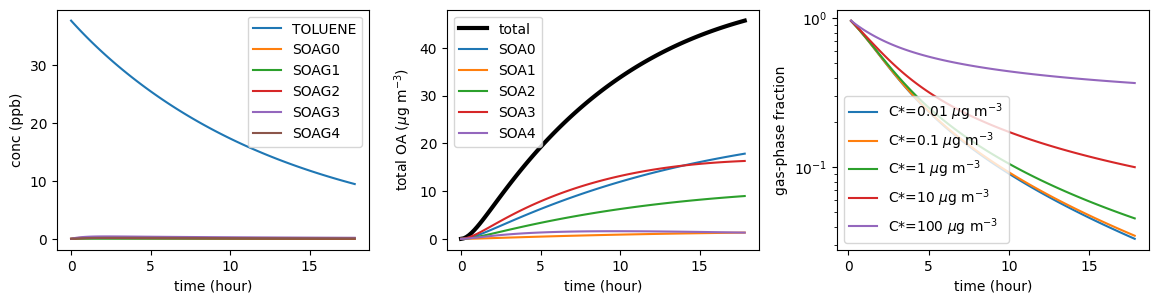

In [101]:
start_time = time.time()

def kmt_gas_aerosol(in_radius_cm, in_Dg_cm2_s, in_N_cm3, in_alpha,
                    in_temp, in_press, in_MW_gas_kg_mol):
    MW_air_kg_mol = 0.029
    # DynamicViscosity_kg_m_s = 1.8325e-5*((416.16/(in_temp+120.))*(in_temp/296.16)**1.5)
    DynamicViscosity_kg_m_s = 1.715747771E-5 + 4.722402075E-8 * (in_temp-273.15) \
                            - 3.663027156E-10 * ((in_temp-273.15)**2.0)          \
                            + 1.873236686E-12 * ((in_temp-273.15)**3.0)          \
                            - 8.050218737E-14 * ((in_temp-273.15)**4.0)
    thermalspeed_m_s = np.sqrt(8.0*8.314*in_temp/np.pi/in_MW_gas_kg_mol)
    rho_air_kg_m3 = in_press*MW_air_kg_mol/8.314/in_temp
    # --- NOTE: this mean free path formulation is suited for small molecules in air
    #           for big molecules in air, Equation 9.15 in the Seinfeld & Pandis book is better
    #                  MeanFreePath = 3*Dab/thermalspeed_m_s
    #           that equation involves Dab (binary diffusivity), which depends on a diffusion volume
    #           which depends on the molecule itself (atoms, features such as rings etc).
    #           Fuller et al (1969) gives a table with diffusion volume for "common" molecules
    #           also a way to calculate that for other molecules.
    #           Ref: Fuller et al (1969): https://pubs.acs.org/doi/abs/10.1021/j100845a020
    #           PyCHAM (https://github.com/simonom/PyCHAM) developers indicated that
    #           the two mean free path formulations can vary by up to a factor of 3!
    #           p.s. mean free path calculated in both ways are 10^-8 to 10^-7 m, both look okay.
    MeanFreePath_m = 3.*DynamicViscosity_kg_m_s/rho_air_kg_m3/thermalspeed_m_s
    Kn = (MeanFreePath_m*100.) / in_radius_cm
    f = 0.75*in_alpha*(1.+Kn)/( Kn*(1.+Kn) + 0.283*in_alpha*Kn + 0.75*in_alpha )
    return 4.*np.pi*in_radius_cm*in_Dg_cm2_s*in_N_cm3*f


# ===================================================================
# this calculates the derivatives: dC/dt
# I'm using eval() to get the derivatives from the string expressions
# ===================================================================
def dcodt(t,conc):
    rate = np.zeros(n_reaction)
    dcodt_out = np.zeros(n_spc)
    for n in range(n_reaction): rate[n] = eval(rates_2eval_compiled[n])
    for n in range(n_spc): dcodt_out[n] = eval(derivatives_2eval_compiled[n])
    # dcodt_out[species_list.index('C_gas')] = 0.0
    return dcodt_out  # np.reshape(dcodt_out, (int(n_spc/n_vec_col),n_vec_col))

# ================================
# this calculates jacobian matrix
# will drastically speed things up
# ================================
def jac(t,conc):
    jac_out = np.zeros((n_spc,n_spc))
    exec(jac_compiled)
    return jac_out

# ===================
# Model configuration
# ===================
# --- time stamps
total_run_time_days = 18.*3600./86400         # how long you want to run the model?
output_frequency_seconds = 600           # how often do you save the output?
# total_run_time_days = 3600./86400         # how long you want to run the model?
# output_frequency_seconds = 60           # how often do you save the output?
tout_s = np.arange(0,total_run_time_days*86400,output_frequency_seconds)  # output time stamps, unit: second

# ================================
# Which chemical mechanism to use?
# ================================
in_ChemMech = ChemMech_merge
species_list, reactions, rates_2eval, derivatives_2eval, rate_coeff_express_2eval, jac_2eval, RO2_sum_2eval = pre_process(in_ChemMech)
n_spc = len(species_list)             # number of species
n_reaction = len(in_ChemMech.columns) # number of reactions
print('Chemical mechanism: %d species and %d reactions' % (n_spc,n_reaction))
# print('Done processing the mechanism in: %.6f seconds' % (time.time() - start_time))
start_time = time.time()

# --- prepare arrays
rate_coeff = np.zeros(n_reaction)
conc = np.zeros((len(tout_s),n_spc))                 # this stores the concentrations. unit: molec/cm3
reaction_rates = np.zeros((len(tout_s),n_reaction))  # this stores the instantaneous rates. unit: molec/cm3/s
conc_init = pd.DataFrame(np.zeros(n_spc)).T          # initial conditions packed into a dataframe so it's easy to use
conc_init.columns = species_list
dcodt_out = np.zeros(n_spc)
jac_out = np.zeros((n_spc,n_spc))

# --- pre-compile so it's much faster to evaluate later
rates_2eval_compiled = [compile(r, '<string>', 'eval') for r in rates_2eval]
derivatives_2eval_compiled = [compile(r, '<string>', 'eval') for r in derivatives_2eval]
RO2_sum_compiled = compile(RO2_sum_2eval, '<string>', 'exec')
jac_compiled = compile(jac_2eval, '<string>', 'exec')
RO2_sum_out_compiled = compile(RO2_sum_2eval.split('=')[1].replace('conc[','conc[i,'), '<string>', 'eval')

# --- special kinetics in MCM: this is directly pulled from MCM
k_label = ['KRO2NO','KRO2HO2','KAPHO2','KAPNO','KRO2NO3','KNO3AL','KDEC','KROPRIM','KROSEC','KCH3O2',
           'K298CH3O2','K14ISOM1','KBPAN','KFPAN','KMT01','KMT02','KMT03','KMT04','KMT05','KMT06','KMT07',
           'KMT08','KMT09','KMT10','KMT11','KMT12','KMT13','KMT14','KMT15','KMT16','KMT17','KMT18','KPPN0',
           'KPPNI','KRPPN','FCPPN','NCPPN','FPPN','KBPPN','KNO','KHO2','KRO2','KNO3','KTR','K16ISOM']

# ==============
# User inputs...
# ==============
# --- this is the solar zenith angle for the j-value parameterization (MCM)
SZA = 60. * np.pi / 180.

# --- environmental conditions
temp = 298      # Kelvin
press = 101325. # Pa
RH = 6.
M = press*6.0232E+17/8.314/temp  # air density. molec/cm3
N2,O2 = 0.78*M, 0.21*M
H2O = ((RH/100.)*6.1078*np.exp(17.269*(temp-273.3)/temp)*100./8.314/temp)*6.0232e+23/1000000.
RO2 = 0         # total RO2 concentration (molec/cm3). MCM needs this. not really saved
RO2_ts = []     # this is a MCM thing


# --- Kelvin effect
surface_tension_water_N_m = 0.072   # Pruppacher and Klett (1997). For water. Often used for aerosols too
if_Kelvin = True

# --- density, molecular weight, mass accommodation coefficient of the condensing materials
rho_g_cm3 = 1.
MW_g_mol = 250.
mass_accommodation_coeff = 2e-3 # 0.1

# --- seed aerosols
seed_ug_m3 = rho_g_cm3*((4./3.)*np.pi*(0.5*init_bin_center_um*1e-4)**3.)*init_bin_N_cm3*1000000.*1000000.
seed_MW_g_mol = 132.   # ammonium sulfate seed

# --- initial condition. need to convert to molec/cm3
conc_init['TOLUENE'] = (37.6)     *press*(6.0232E+8)/(8.314*temp)
conc_init['H2O2'] = (2000.)     *press*(6.0232E+8)/(8.314*temp)

# --- volatility bins
Cstar_volatility_bins_ug_m3 = np.array([0.01, 0.1, 1., 10., 100.])

# --- set up vapor wall loss: assume it's ireversible for now
kwall = 2.5e-4

# --- set intial values for the kinetics
kmt = np.zeros(len(init_bin_center_um))
kmt_Cstar_f = np.zeros((len(Cstar_volatility_bins_ug_m3), len(init_bin_center_um)))
new_Dp_um = np.zeros(len(init_bin_center_um))
m_per_particle_g = np.zeros(len(init_bin_center_um))
for ibin in range(len(init_bin_center_um)):
    if if_Kelvin: KelvinFactor = np.exp(4.*MW_g_mol*surface_tension_water_N_m/8.314/temp/(rho_g_cm3*1000000.)/(init_bin_center_um[ibin]*1e-6))
    else: KelvinFactor = 1.
    kmt[ibin] = kmt_gas_aerosol(0.5*init_bin_center_um[ibin]*1e-4, 0.1, init_bin_N_cm3[ibin], mass_accommodation_coeff, temp, press, MW_g_mol/1000.)
    for ivbs in range(len(Cstar_volatility_bins_ug_m3)):
        kmt_Cstar_f[ivbs,ibin] = kmt[ibin] * KelvinFactor*Cstar_volatility_bins_ug_m3[ivbs]/MW_g_mol / (seed_ug_m3[ibin]/seed_MW_g_mol)
        # kmt_Cstar_f[ivbs,ibin] = kmt[ibin] * KelvinFactor*Cstar_volatility_bins_ug_m3[ivbs] / (seed_ug_m3[ibin])


# ========================
# loop over all time steps
# ========================
Dp_um_time = np.zeros((len(tout_s),len(init_bin_center_um)))
dN_dlogDp_time = np.zeros((len(tout_s),len(init_bin_center_um)))
tout_s_3d = np.zeros((len(tout_s),len(init_bin_center_um)))
for i,t in enumerate(tout_s):
    # print(i,t)
    # --- update photolysis frequencies
    jval = mcm_jval(SZA)
    # --- update generic rate coefficients
    if ('HO2' in species_list) & ('NO' in species_list):
        mcm_kinetics = pd_mcm_kinetics(temp,M,N2,O2,H2O,
                                       conc[max(i-1,0),species_list.index('NO')], # only needed for K16ISOM
                                       conc[max(i-1,0),species_list.index('HO2')], RO2)
    else: mcm_kinetics = pd_mcm_kinetics(temp,M,N2,O2,H2O)
    for k in k_label: exec("%s = np.array(mcm_kinetics['%s'])[0]" % (k,k))
    # --- need to update all environmental variables, mcm kinetics, jval before eval()
    for n in range(n_reaction): rate_coeff[n] = eval(rate_coeff_express_2eval[n])
    # --- any final updates to the kinetics?
    # --- now solve the ODE. Use BDF since it's mostly stiff
    #     accuracy controlled by relative/absolute tolerance (rtol,atol)
    #     integrate step by step, since some env variables may change over the course of time
    if i==0: conc[i,:] = conc_init
    else: conc[i,:] = solve_ivp(dcodt,tout_s[0:2],conc[i-1,:],t_eval=[output_frequency_seconds],
                                jac=jac, method='BDF', rtol=1e-5,atol=1e-3).y[:,0]
    # --- get instantaneous rates. unit: molec/cm3/s
    for n_reac,reaction in enumerate(reactions):
        reactants = reaction.split(' = ')[0].split(' + ')
        # --- 20250407: add support for zero-order reactions
        if len(''.join(reactants).replace(' ',''))!=0:
            spc_ind = [species_list.index(spc.replace(' ','')) for spc in reactants]
            rate_temp = rate_coeff[n_reac]
            for ind in spc_ind: rate_temp = rate_temp * conc[i,ind]
            reaction_rates[i,n_reac] = rate_temp
        else:
            reaction_rates[i,n_reac] = rate_coeff[n_reac]
    # --- get total RO2
    RO2 = eval(RO2_sum_out_compiled)
    RO2_ts.append(RO2)

    # --- update size and kinetics
    for ibin in range(len(init_bin_center_um)):
        # --- calculate total SOA in each size bin, also total SOA per particle
        tot_OA_per_particle_g, tot_OA_per_bin_ug_m3 = 0., 0.
        for ivbs in range(len(Cstar_volatility_bins_ug_m3)):
            tot_OA_per_particle_g += conc[i,species_list.index('SOA'+str(ivbs)+'_bin'+str(ibin))]/init_bin_N_cm3[ibin]/6.0232e+23*MW_g_mol
            tot_OA_per_bin_ug_m3 += conc[i,species_list.index('SOA'+str(ivbs)+'_bin'+str(ibin))]*MW_g_mol/6.0232e+11
        # --- new aerosol mass: per particle. seed mass + SOA mass
        m_per_particle_g[ibin] = seed_ug_m3[ibin]*1e-6/1000000./init_bin_N_cm3[ibin] + tot_OA_per_particle_g
        # --- get new aerosol size
        new_Dp_um[ibin] = 2.*1e+4*((m_per_particle_g[ibin]/rho_g_cm3)*(3./4.)/np.pi)**(1./3.)
        # --- Kelvin effect
        if if_Kelvin: KelvinFactor = np.exp(4.*MW_g_mol*surface_tension_water_N_m/8.314/temp/(rho_g_cm3*1000000.)/(new_Dp_um[ibin]*1e-6))
        else: KelvinFactor = 1.
        # --- update kinetics
        kmt[ibin] = kmt_gas_aerosol(0.5*new_Dp_um[ibin]*1e-4, 0.1, init_bin_N_cm3[ibin], mass_accommodation_coeff, temp, press, MW_g_mol/1000.)
        for ivbs in range(len(Cstar_volatility_bins_ug_m3)):
            kmt_Cstar_f[ivbs,ibin] = kmt[ibin] * KelvinFactor*Cstar_volatility_bins_ug_m3[ivbs]/MW_g_mol / (seed_ug_m3[ibin]/seed_MW_g_mol+tot_OA_per_bin_ug_m3/MW_g_mol)
            # kmt_Cstar_f[ivbs,ibin] = kmt[ibin] * KelvinFactor*Cstar_volatility_bins_ug_m3[ivbs] / (seed_ug_m3[ibin]+tot_OA_per_bin_ug_m3)

    # --- update bins and archive
    Dp_um_time[i,:] = new_Dp_um
    dN_dlogDp_time[i,:] = init_bin_N_cm3/np.diff(np.log10(get_bin_bounds(new_Dp_um)))
    tout_s_3d[i,:] = np.ones(len(init_bin_center_um))*t

# --- calculate bin bounds and relevant distributions
final_Dp_um = Dp_um_time[-1,:]
final_Dp_bounds_um = get_bin_bounds(final_Dp_um)
final_dN_dlogDp_cm3 = init_bin_N_cm3/np.diff(np.log10(final_Dp_bounds_um))
final_dN_dDp_cm3 = init_bin_N_cm3/np.diff(final_Dp_bounds_um)
final_dV_dlogDp_nm3_cm3 = init_bin_N_cm3*((4./3.)*np.pi*(0.5*final_Dp_um*1000.)**3.)/np.diff(np.log10(final_Dp_bounds_um))


# --- pack the concentration outputs (in molec/cm3) into a DataFrame
conc = pd.DataFrame(conc)
conc.columns = species_list
conc['total_RO2'] = RO2_ts
# conc['NOx'] = conc['NO']+conc['NO2']

# --- pack the rate outputs (in molec/cm3/s) into a DataFrame
reaction_rates = pd.DataFrame(reaction_rates)
reaction_rates.columns = in_ChemMech.columns

# --- calculate the total OA
total_OA_ug_m3 = np.zeros(len(tout_s))
for ibin in range(len(init_bin_center_um)):
    for ivbs in range(len(Cstar_volatility_bins_ug_m3)):
        total_OA_ug_m3 += conc['SOA'+str(ivbs)+'_bin'+str(ibin)]*MW_g_mol/6.0232e+11

# --- calculate each VBS component
OA_VBS_spc_ug_m3 = np.zeros((len(tout_s),len(Cstar_volatility_bins_ug_m3)))
for ivbs in range(len(Cstar_volatility_bins_ug_m3)):
    OA_allbins = np.zeros(len(tout_s))
    for ibin in range(len(init_bin_center_um)):
        OA_allbins += conc['SOA%d_bin%d' % (ivbs,ibin)]*MW_g_mol/6.0232e+11
    OA_VBS_spc_ug_m3[:,ivbs] = OA_allbins


wrapup_str = 'YAMCHA: Yet Another Model for Chemistry Happening in the Air\n'
wrapup_str = wrapup_str + 'Total run time: %.2f days (%.2f hours)\n' % (total_run_time_days, total_run_time_days*24)
wrapup_str = wrapup_str + 'Output frequency: %.2f seconds | %d steps\n' % (output_frequency_seconds, total_run_time_days*86400/output_frequency_seconds)
wrapup_str = wrapup_str + 'Time elapsed: %.6f seconds' % (time.time() - start_time)
print( wrapup_str )


fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(13,3))
# --- gas-phase decay
for s in ['TOLUENE','SOAG0','SOAG1','SOAG2','SOAG3','SOAG4']:
    axs[0].plot(tout_s/3600,conc[s]/(press*(6.0232E+8)/(8.314*temp)),'-',label=s)
axs[0].set_ylabel('conc (ppb)')
# --- aerosol-phase
axs[1].plot(tout_s/3600,total_OA_ug_m3,'k-',lw=3,label='total')
for ivbs in range(len(Cstar_volatility_bins_ug_m3)):
    axs[1].plot(tout_s/3600,OA_VBS_spc_ug_m3[:,ivbs],'-',label='SOA%d' % (ivbs))
axs[1].set_ylabel(r'total OA ($\mu$g m$^{-3}$)')
# --- gas-phase molar fraction
for ivbs in range(len(Cstar_volatility_bins_ug_m3)):
    axs[2].plot(tout_s/3600,conc['SOAG%d' % (ivbs)]/(OA_VBS_spc_ug_m3[:,ivbs]/MW_g_mol*6.0232e+11+conc['SOAG%d' % (ivbs)]),
                label=r'C*=%g $\mu$g m$^{-3}$' % (Cstar_volatility_bins_ug_m3[ivbs]))
axs[2].set_yscale('log')
axs[2].set_ylabel('gas-phase fraction')
for ax in axs:
    ax.set_xlabel('time (hour)')
    ax.legend()
plt.subplots_adjust(top=0.95, bottom=0.15, left=0.15, right=0.99, hspace=0.35, wspace=0.25)
plt.show()


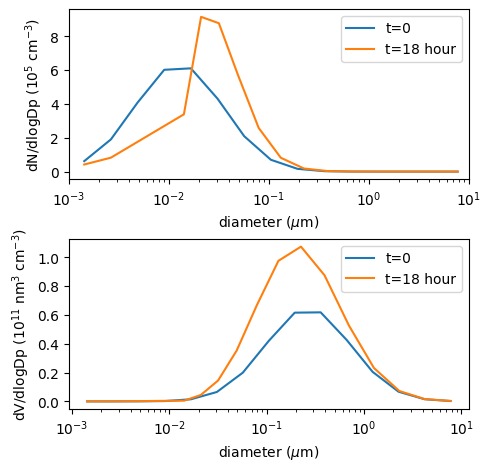

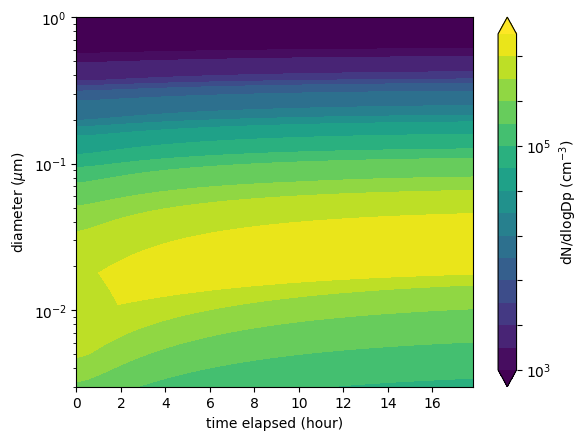

In [102]:
fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(5,5))
yscaling = int(np.log10(np.nanmax(final_dN_dlogDp_cm3)))
axs[0].plot(init_bin_center_um,init_dN_dlogDp_cm3/(10**yscaling),label='t=0')
axs[0].plot(final_Dp_um,final_dN_dlogDp_cm3/(10**yscaling),label='t=%.0f hour'%(tout_s[-1]/3600))
axs[0].set_ylabel(r'dN/dlogDp (10$^%d$ cm$^{-3}$)' % (yscaling))
yscaling = int(np.log10(np.nanmax(final_dV_dlogDp_nm3_cm3)))
axs[1].plot(init_bin_center_um,init_dV_dlogDp_nm3_cm3/(10**yscaling),'-',label='t=0')
axs[1].plot(final_Dp_um,final_dV_dlogDp_nm3_cm3/(10**yscaling),'-',label='t=%.0f hour'%(tout_s[-1]/3600))
axs[1].set_ylabel(r'dV/dlogDp (10$^{%d}$ nm$^3$ cm$^{-3}$)' % (yscaling))
for ax in axs:
    axs[0].set_xlim([0.001,10])
    ax.set_xlabel(r'diameter ($\mu$m)')
    ax.set_xscale('log')
    ax.legend()
plt.subplots_adjust(top=0.95, bottom=0.15, left=0.15, right=0.95, hspace=0.35, wspace=0.3)
plt.show()

plt.contourf(tout_s_3d/3600,Dp_um_time,dN_dlogDp_time,10**np.arange(3,6.2,0.2),norm=LogNorm(),extend='both')
plt.ylim([0.003,1])
plt.yscale('log')
plt.ylabel(r'diameter ($\mu$m)')
plt.xlabel(r'time elapsed (hour)')
plt.colorbar(label=r'dN/dlogDp (cm$^{-3}$)')
plt.show()

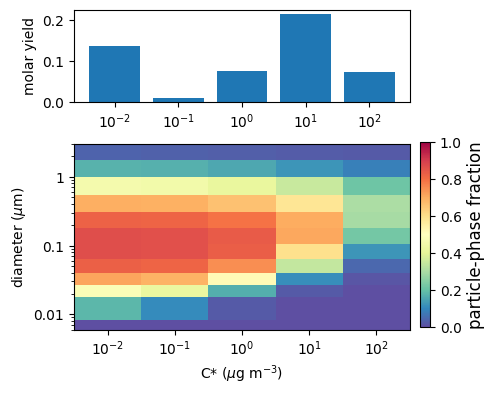

In [103]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

frac_aer = np.zeros((len(Cstar_volatility_bins_ug_m3),len(final_Dp_um)))
for ivbs in range(len(Cstar_volatility_bins_ug_m3)):
    for ibin in range(len(final_Dp_um)):
        # print(ivbs, ibin)
        conc_g = conc['SOAG%d'%(ivbs)].values[-1]
        conc_a = conc['SOA%d_bin%d'%(ivbs,ibin)].values[-1]
        frac_aer[ivbs,ibin] = conc_a/(conc_a+conc_g)


Cstar_category = [0,1,2,3,4]
SOA_yields = [0.1364, 0.0101, 0.0763, 0.2157, 0.0738]

fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(4,4),gridspec_kw={'height_ratios': [1,2]})
axs[0].bar(Cstar_category, SOA_yields)
im = axs[1].pcolormesh(Cstar_category, final_Dp_um, frac_aer.T, vmin=0, vmax=1, cmap='Spectral_r')

def add_colorbar(in_im, in_ax, in_bbox, in_label):
    axins0 = inset_axes(in_ax,width='3%',height='100%',bbox_to_anchor=in_bbox,bbox_transform=in_ax.transAxes)
    axins0.grid(False)
    cbar0 = fig.colorbar(in_im, cax=axins0, orientation='vertical', extend='neither')#, ticks=in_ticks)
    cbar0.set_label(in_label,fontsize=12,color='k')
    cbar0.ax.tick_params(axis='x',labelsize=12,colors='k')
add_colorbar(im, axs[1], (0.08,0.05,1,1), 'particle-phase fraction')

axs[1].set_yscale('log')
axs[1].set_yticks([0.01,0.1,1])
axs[1].set_yticklabels([0.01,0.1,1])

for ax in axs:
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(['10$^{-2}$','10$^{-1}$','10$^{0}$','10$^{1}$','10$^{2}$'])

axs[1].set_xlabel(r'C* ($\mu$g m$^{-3}$)')
axs[0].set_ylabel(r'molar yield')
axs[1].set_ylabel(r'diameter ($\mu$m)')
axs[1].set_ylim([0.006,3])
plt.subplots_adjust(top=0.95, bottom=0.15, left=0.15, right=0.99, hspace=0.3, wspace=0.25)